In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Input, Lambda, Activation, Dense, Dropout, Flatten, Add, Reshape, Dot
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [5]:
ratings_df = pd.read_csv('ml-100k/ratings.csv')
movies_df = pd.read_csv('ml-100k/movies.csv')

In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
ratings_df.drop(['timestamp'], axis=1, inplace=True)

In [11]:
user_encoder = LabelEncoder()
ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'].values)
total_users = ratings_df['user'].nunique()

movie_encoder = LabelEncoder()
ratings_df['movie'] = movie_encoder.fit_transform(ratings_df['movieId'].values)
total_movies = ratings_df['movie'].nunique()

In [12]:
ratings_df['rating'] = ratings_df['rating'].values.astype(np.float32)

In [13]:
X = ratings_df[['user', 'movie']].values
y = ratings_df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [17]:
n_factors = 50
X_train_arr = [X_train[:, 0], X_train[:, 1]]
X_test_arr = [X_test[:, 0], X_test[:, 1]]

In [11]:
# Adding a bias to each embedding and using additional sigmoid layer and scaling the result

In [18]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    

In [19]:
def Recommender(total_user, total_movie, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    user_emb = EmbeddingLayer(total_user, n_factors)(user)
    ub = EmbeddingLayer(total_user, 1)(user)
    
    movie = Input(shape=(1,))
    movie_emb = EmbeddingLayer(total_movie, n_factors)(movie)
    mb = EmbeddingLayer(total_movie, 1)(movie)
    x = Dot(axes=1)([user_emb, movie_emb])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    return model

In [20]:
model = Recommender(total_users, total_movies, n_factors, min(ratings_df['rating']), max(ratings_df['rating']))

In [21]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

In [23]:
hist = model.fit(x=X_train_arr, y=y_train, batch_size=64, epochs=5,
                    verbose=2, validation_data=(X_test_arr, y_test))

Epoch 1/5
1418/1418 - 5s - loss: 1.2028 - val_loss: 0.8421
Epoch 2/5
1418/1418 - 4s - loss: 0.7003 - val_loss: 0.7333
Epoch 3/5
1418/1418 - 4s - loss: 0.5305 - val_loss: 0.7117
Epoch 4/5
1418/1418 - 3s - loss: 0.4021 - val_loss: 0.7178
Epoch 5/5
1418/1418 - 3s - loss: 0.3078 - val_loss: 0.7340


In [26]:
val_loss = min(hist.history['val_loss'])
val_loss

0.7116998434066772

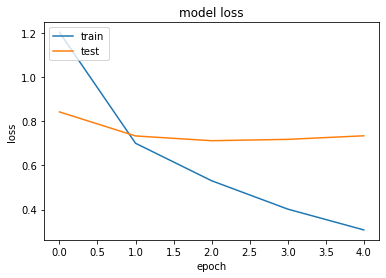

In [28]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()